## Data Analysis

In [7]:
#Define constants
EXP_VARIABLES = 'BS'
EXP_SET="/openimage-train-coco-finetune"
DATA_PATH = os.getcwd() + "/experiments" + EXP_SET

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import glob, os
import ast

In [4]:
def load_values(targets, target, line):
    data_dict = ast.literal_eval(line[9:])
    try:
        if isinstance(targets[target], list):
            targets[target].append(data_dict['value'])
        else:
            targets[target] = data_dict['value']
    except ValueError:
        print("Encountered Value Error... Ignoring")
    return targets

def load_accuracy(targets, acc, epoch_num, line):
    data_dict = ast.literal_eval(line[9:])
    try:
        targets[acc].append(data_dict['value'])
        targets[epoch_num].append(data_dict['metadata'][epoch_num])
    except ValueError:
        print("Encountered Value Error... Ignoring")
    return targets

In [5]:
frames = []

# os.chdir(DATA_PATH)
for idx, file in enumerate(glob.glob(DATA_PATH+'/*/*.log')):
    print("Opening ", file)
    acc_targets = {
        "eval_accuracy":[],
        "epoch_num":[]
    }
    targets = {
        "global_batch_size":None, 
    }
    with open(file) as f:
        for line in f:
            if re.search("eval_accuracy", line):
                load_accuracy(acc_targets, "eval_accuracy", "epoch_num", line)
            for target in targets.keys():
                if re.search(target, line):
                    load_values(targets, target, line)
    targets.update(acc_targets)
    n = len(targets['epoch_num'])
    column_list = list(zip(t*n if isinstance(t, list) else t for t in targets))
    for t in targets:
        if isinstance(targets[t], int):
            targets[t] = [targets[t]]*n
    df = pd.DataFrame.from_dict(targets)
    frames.append(df)



if len(frames) != 1:
    data = pd.concat(frames)
else:
    data = frames[0]
data = data.reset_index(drop=True)
data[EXP_VARIABLES] = data["global_batch_size"].astype(str)

Opening  /home/elim/mlperf-training/training/single_stage_detector/ssd/model_and_results/experiments/openimage-train-coco-finetune/220608200706941989424/220608200706941989424.log
Opening  /home/elim/mlperf-training/training/single_stage_detector/ssd/model_and_results/experiments/openimage-train-coco-finetune/220606192017545931369/220606192017545931369.log


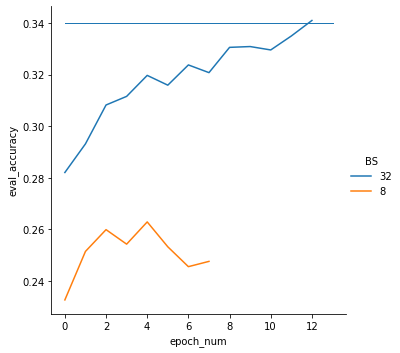

In [6]:
THRESHOLD = 0.3400
p = sns.relplot(data=data, kind="line", x="epoch_num", y="eval_accuracy", hue=EXP_VARIABLES)
p.axes[0, 0].plot((0, 13), (THRESHOLD, THRESHOLD), linewidth=1)